In [1]:
# -*- coding: utf-8-*-
import sys
import os
import warnings
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import drpy
import glob
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import shapely.geometry as sgeom
from matplotlib.gridspec import GridSpec
from datetime import datetime
import scipy.stats as ss
import random
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import functools
import operator
from re import split
from matplotlib.animation import ArtistAnimation
warnings.filterwarnings('ignore')
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
import pandas as pd
from datetime import datetime, date, time
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pyart
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import math
import os, sys

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import time_3d, get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']
path_proj = get_pars_from_ini(file_name='loc')[location]['path_proj']
plt.rcParams['animation.html'] = 'jshtml'
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def get_data(instrument='Lear', temp=2):
    """
    :param instrument: aircraft
    :param temp: temperature for filtering
    :return: list of available dataframe in camp2ex
    """
    if instrument == 'Lear':
        ls_lear = glob.glob(f'{path_data}/data/LAWSON.PAUL/LEARJET/all/*.pkl')
        lear_df = [pd.read_pickle(i) for i in ls_lear]
        _attrs = [i.attrs for i in lear_df[1:]]
        if temp:
            lear_df = [pd.merge(i, lear_df[0]['Temp'], right_index=True, left_index=True) for i in lear_df[1:]]
            lear_df = [i[i['Temp'] > temp] for i in lear_df]
        for i, attrs in enumerate(_attrs):
            lear_df[i].attrs = attrs
        return lear_df
    
    elif instrument == 'P3B':
        ls_p3 = glob.glob(f'{path_data}/data/LAWSON.PAUL/P3B/all/*.pkl')
        p3_merged = glob.glob(f'{path_data}/data/01_SECOND.P3B_MRG/MERGE/all/*pkl')
        print(p3_merged)
        p3_temp = pd.read_pickle(p3_merged[0])
        p3_df = [pd.read_pickle(i) for i in ls_p3]
        _attrs = [i.attrs for i in p3_df]
        p3_df = [pd.merge(i, p3_temp[' Static_Air_Temp_YANG_MetNav'], left_index=True, right_index=True) for i in p3_df]
        temp = 2
        for i, df in enumerate(p3_df):
            df.attrs = _attrs[i]
            df.rename(columns={' Static_Air_Temp_YANG_MetNav': 'Temp'}, inplace=True)
            if temp:
                df = df[df['Temp'] >= temp]
            p3_df[i] = df
        return p3_df
    else:
        raise TypeError(f"{instrument} not available. Use Lear or P3B")

In [3]:
def check_bimodality2(sr, aircraft, idx):
    sr = sr.dropna()
    log_d = np.log10(sr.index).to_numpy().reshape((-1, 1))
    log_psd = np.ma.masked_invalid(np.log10(sr.values))

    xp = np.linspace(log_d.min(), log_d.max(), 300)
    yp = np.interp(xp, log_d.flatten(), log_psd.flatten())

    smoothed_int = apply_smooth(x=xp, y=yp, hwz=35)
    model = LinearRegression().fit(xp.reshape(-1, 1), yp.reshape(-1, 1))
    y_pred_interp = model.intercept_ + model.coef_ * xp

    diff_interp = yp - y_pred_interp
    smoothed_res = apply_smooth(xp, diff_interp.flatten(), hwz=35)

    _idx_smt_res = np.argwhere(smoothed_res.flatten() >= 0)
    smoothed_res = smoothed_res[_idx_smt_res].flatten()
    xp_smt_res = xp[_idx_smt_res]

    yinterp = savgol_filter(yp, 51, 3)
    diff_savgol = yinterp - y_pred_interp.flatten()

    xp_dff_savgol = xp

    peaks_smooth, prop_smt = find_peaks(smoothed_res, height=0, prominence=0.0, width=10)
    peaks_savgol, prop_sav = find_peaks(diff_savgol, height=0, prominence=0.0, width=10)

    if len(peaks_savgol) >= 2:
        return idx, len(peaks_savgol)
    else:
        return idx, np.nan
    
def change_cols(df):
#     print(df)
    df = df.filter(like='nsd')
    bin_cent = df.attrs['bin_cent']
    cols = df.columns
    new_cols = {cols[i]: bin_cent[i] for i in range(len(cols))}
    df = df.rename(columns=new_cols)
    if df.empty:
        return pd.Series(index=bin_cent, name=f"{df.attrs['instrument']}", dtype='float64')
    else:
        return pd.Series(data=df.where(df > 0).T.iloc[1:, 0], name=f"{df.attrs['instrument']}")
    
def get_convolution(array, half_window_size):
    array = np.concatenate((np.repeat(array[0], half_window_size),
                            array,
                            np.repeat(array[-1], half_window_size)))
    window_inds = [list(range(ind - half_window_size, ind + half_window_size + 1)) \
                   for ind in range(half_window_size, len(array) - half_window_size)]

    return np.take(array, window_inds)


def apply_smooth(x, y, hwz=20):
    x_conv = np.apply_along_axis(g_func, axis=1, arr=get_convolution(x, half_window_size=hwz))
    y_conv = get_convolution(y, half_window_size=hwz)
    y_mean = np.mean(y_conv, axis=1)
    y_centered = y_conv - y_mean[:, None]
    smoothed = np.sum(x_conv * y_centered, axis=1) / (hwz * 2) + y_mean
    return smoothed

def g_func(xx):
    std = len(xx)
    mean = np.mean(xx)
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-1 / 2 * ((xx - mean) / std) ** 2)


def plot_mean(df_new, idx, aircraft):
    for index, row in df_new.iterrows():
#         idx = row.name
        fig, ax = plt.subplots()
        print(row.index)
        ax.step(x=row.index, y=row.values.flatten(), where='post', label='mean')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Particle size (um)')
        ax.set_ylabel('Concentration (# L-1 um-1)')
        ax.legend()
        ax.xaxis.grid(which='both')
        title = f"{idx: %Y-%m-%d %H:%M:%S} UTC - {aircraft}"
        fig.suptitle(title, fontsize=14, fontweight='bold', y=0.92)
        plt.show()

In [4]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

In [5]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='2:30:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7999'})

In [6]:
# cluster.scale(2)
cluster.scale(jobs=4)
cluster

In [7]:
client = Client(cluster)
client

Client Scheduler: tcp://172.22.179.3:7223 Dashboard: /proxy/7999/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')

In [9]:
 _, index = np.unique(ds_xr['time'], return_index=True)
ds_nw = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

In [10]:
ds_dates = ds_nw.sel(time=slice('2019-09-15 22:18:00','2019-09-15 22:30:00'))

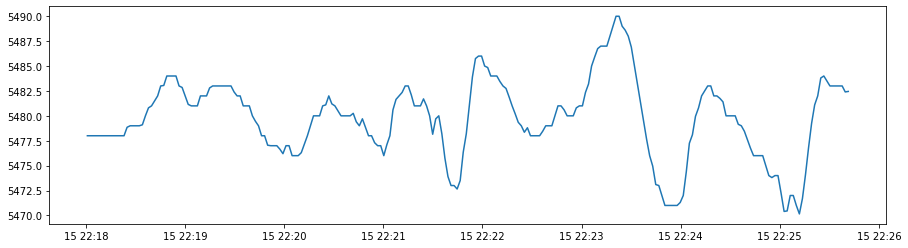

In [11]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ds_dates.time, ds_dates.alt_nav[12, :])

(0.0, 6000.0)

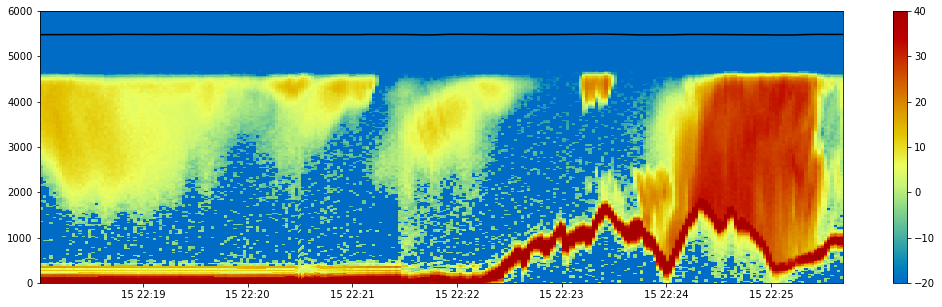

In [12]:
fig = plt.figure(figsize=(18, 5))
ax3 = fig.add_subplot()
time_3D = time_3d(ds_dates.scantime, ds_dates.alt3D.shape[0])
im3 = ax3.pcolormesh(time_3D[:, 12, :],
                       ds_dates.alt3D[:, 12, :],
#                        np.where(ds_dates.z95s[:, 12, :]< 0, np.nan, ds_dates.zhh14[:, 12, :]),
                       ds_dates.zhh35[:, 12, :],
                       cmap=drpy.graph.cmaps.HomeyerRainbow, vmin=-20, vmax=40)

ax3.plot(time_3D[0, 12, :], ds_dates.alt_nav[12, :], 'k')
plt.colorbar(im3)
ax3.set_ylim(0, 6000)

In [13]:
ls_df = get_data('Lear', 2)

In [14]:
ls_idx = [i.index for i in ls_df]
ls_idx = functools.reduce(operator.iconcat, ls_idx, [])
print(len(ls_idx))
ls_idx = sorted(list(set(ls_idx)))
print(len(ls_idx))

409560
62223


In [15]:
rdm_idx = pd.date_range(start='2019-09-07 2:31:50', periods=80, tz='UTC', freq='S')

In [16]:
%%time
ls_all = []
sr_mean = pd.Series(index=np.arange(1, 40000, 0.5), name='psd_nan', dtype='float64')
for idx in rdm_idx[7:8]:
    _ls_df = [change_cols(i.loc[i.index == idx]) for i in ls_df]
    hawk = False # False: Hackeye instrument not taken into account. 
    if not hawk:
        _ls_df = [i for i in _ls_df if not i.name.startswith('Hawk')]
    _ls_df.append(sr_mean)
    df_new = pd.concat(_ls_df, axis=1)
#     df_new[idx] = df_new[df_new > 0.1].mean(axis=1)#.interpolate('pad', limit=100)
#     ls_all.append(df_new[idx])


CPU times: user 74.1 ms, sys: 7.83 ms, total: 81.9 ms
Wall time: 76.5 ms


In [27]:
df_new.T.dropna(how='all')

,2.25,3.75,5.25,7.00,9.00,11.00,13.00,15.00,17.00,19.50,...,39995.00,39995.50,39996.00,39996.50,39997.00,39997.50,39998.00,39998.50,39999.00,39999.50
FCDP,58.2039,118.7525,356.5718,920.8903,1555.3587,2249.1174,2679.0675,2584.5871,2603.3642,4409.6555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2DS10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HVPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FFSSP,NaN,233.2000,2247.0000,2687.0000,2655.0000,3164.0000,3672.0000,3195.0000,3466.0000,4282.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Float64Index([   2.25,    3.75,    5.25,     7.0,     9.0,    11.0,    13.0,
                 15.0,    17.0,    19.5,
              ...
              39995.0, 39995.5, 39996.0, 39996.5, 39997.0, 39997.5, 39998.0,
              39998.5, 39999.0, 39999.5],
             dtype='float64', length=80004)


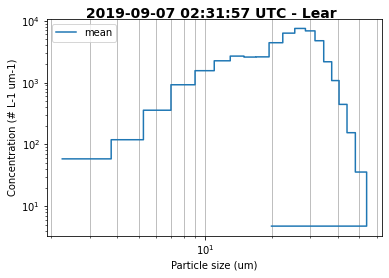

Float64Index([   2.25,    3.75,    5.25,     7.0,     9.0,    11.0,    13.0,
                 15.0,    17.0,    19.5,
              ...
              39995.0, 39995.5, 39996.0, 39996.5, 39997.0, 39997.5, 39998.0,
              39998.5, 39999.0, 39999.5],
             dtype='float64', length=80004)


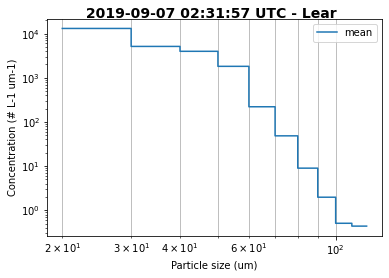

Float64Index([   2.25,    3.75,    5.25,     7.0,     9.0,    11.0,    13.0,
                 15.0,    17.0,    19.5,
              ...
              39995.0, 39995.5, 39996.0, 39996.5, 39997.0, 39997.5, 39998.0,
              39998.5, 39999.0, 39999.5],
             dtype='float64', length=80004)


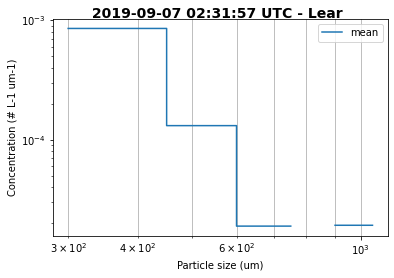

Float64Index([   2.25,    3.75,    5.25,     7.0,     9.0,    11.0,    13.0,
                 15.0,    17.0,    19.5,
              ...
              39995.0, 39995.5, 39996.0, 39996.5, 39997.0, 39997.5, 39998.0,
              39998.5, 39999.0, 39999.5],
             dtype='float64', length=80004)


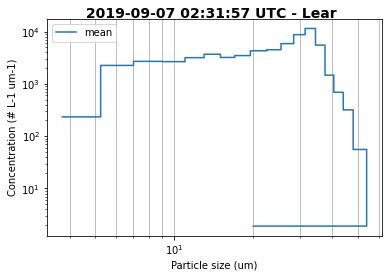

Float64Index([   2.25,    3.75,    5.25,     7.0,     9.0,    11.0,    13.0,
                 15.0,    17.0,    19.5,
              ...
              39995.0, 39995.5, 39996.0, 39996.5, 39997.0, 39997.5, 39998.0,
              39998.5, 39999.0, 39999.5],
             dtype='float64', length=80004)


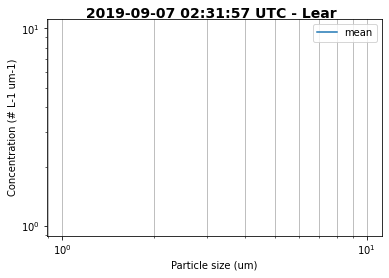

In [18]:
plot_mean(df_new.T, idx, 'Lear')

In [19]:
df_merged = pd.concat(ls_all, axis=1).T

ValueError: No objects to concatenate

In [ ]:
df_new.T

In [ ]:
# xr_merg = xr.Dataset(
#     data_vars=dict(
#         merge_psd=(["time","diameter"],df_merged.to_numpy())),
#     coords=dict(
#         time=(["time"],df_merged.index.to_pydatetime()),
#         diameter=(["diameter"],df_merged.columns)),
#     attrs=dict(description="combined psd"),
#     )

In [ ]:
df_day = df_merged.groupby(df_merged.index.floor('d'))
keys = list(df_day.groups.keys())
for i, key in enumerate(keys):
    print(i, key)

In [ ]:
for key in keys:
    airc = ls_df[0].attrs['aircraft']
    df = df_merged.groupby(df_merged.index.floor('d')).get_group(key)
    df = df[df>=1]
    fig, ax = plt.subplots(figsize=(12,4.5))
    cbar =  ax.pcolormesh(df.index, df.columns, np.log10(df.T), vmin=0, vmax=5, cmap='jet')
    plt.colorbar(cbar, pad=0.01, aspect=20) #.set_ticks(np.arange(0,,1))
    ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
    ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
    plt.title('$N(D), \log_{10} (\# \ mm^{-3} m^{-1}) $',  position=(0.8, 0.85), fontsize='x-large')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_yscale('log')
#     ax.set_ylim(0, 200)
#     title = f"{key: %Y-%m-%d} UTC - {airc}"
#     fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)

In [ ]:
plot_mean(df_merged, idx=1, aircraft='Learjet')

In [ ]:
start = pd.Timestamp(year=2019, month=8, day=27, hour=0, minute=0, second=0, tz='UTC')
end = pd.Timestamp(year=2019, month=8, day=27, hour=0, minute=50, second=0, tz='UTC')

In [ ]:
ls_df = [i[(i.index > start) & (i.index <= end)] for i in ls_df]

In [ ]:
dates = []
peaks = []

for idx in df_merged.index:
    _ls_df = [change_cols(i.loc[i.index == idx]) for i in ls_df]
    hawk = False
    if not hawk:
        _ls_df = [i for i in _ls_df if not i.name.startswith('psd_Hawk')]
    sr_mean = pd.Series(index=np.arange(1, 40000, 0.5), name='psd_nan', dtype='float64')
    _ls_df.append(sr_mean)
    df_new = pd.concat(_ls_df, axis=1)
    try:
        df_new['mean'] = df_new[df_new > 0].mean(axis=1).interpolate('pad', limit=500)
        df_new.drop(columns=['psd_nan'], axis=1, inplace=True)
        date, peak = check_bimodality2(df_new['mean'], ls_df[0].attrs['aircraft'], idx)
        dates.append(idx)
        peaks.append(peak)
    except ValueError:
        dates.append(idx)
        peaks.append(np.nan)
        pass

In [ ]:
df_peaks = pd.DataFrame(peaks, index=dates, columns=['peaks'])
df_peaks

In [ ]:
df_peaks.plot.bar(y='peaks')